In [1]:
import pandas as pd
df = pd.read_csv(r"amazon_reviews_us_Apparel_v1_01.tsv", sep='\t', on_bad_lines='skip',nrows=100000,low_memory=False)
required_columns = [
    'review_headline', 'star_rating', 
    'verified_purchase', 'product_title', 'helpful_votes','total_votes', 'review_body'
]
df = df[required_columns]

# Pre-processing and data-cleaning
df = df.dropna(subset=required_columns)
df.head()
#print(df.info())

,review_headline,star_rating,verified_purchase,product_title,helpful_votes,total_votes,review_body
0,★ THESE REALLY DO WORK GREAT WITH SOME TWEAKING ★,4,Y,Easy Tool Stainless Steel Fruit Pineapple Core...,0,0,"These Really Do Work Great, But You Do Need To..."
1,Favorite for winter. Very warm!,5,Y,V28 Women Cowl Neck Knit Stretchable Elasticit...,1,2,I love this dress. Absolute favorite for winte...
2,Great Socks for the money.,5,Y,James Fiallo Men's 12-Pairs Low Cut Athletic S...,0,0,"Nice socks, great colors, just enough support ..."
3,Slick hat!,5,Y,Belfry Gangster 100% Wool Stain-Resistant Crus...,0,0,"I bought this for my husband and WOW, this is ..."
4,I would do it again!,5,Y,JAEDEN Women's Beaded Spaghetti Straps Sexy Lo...,0,0,Perfect dress and the customer service was awe...


In [2]:
# Feature extraction and selection
import pandas as pd
from textblob import TextBlob
import joblib
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df['sentiment_polarity'] = df['review_body'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['review_length'] = df['review_body'].apply(len)

if 'total_votes' in df.columns and 'helpful_votes' in df.columns:
    df['helpful_ratio'] = df['helpful_votes'] / df['total_votes'].replace(0, 1)  #Avoiding division by zero
else:
    df['helpful_ratio'] = 0 
df_subset = df.head(10000).copy()

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), min_df=2)  
tfidf_matrix = tfidf_vectorizer.fit_transform(df_subset['review_body'].astype(str))
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
print("TF-IDF Vectorizer saved as tfidf_vectorizer.pkl")
cosine_sim = cosine_similarity(tfidf_matrix, dense_output=False)  

threshold = 0.85  
duplicate_flags = np.zeros(len(df_subset), dtype=bool)

for i in range(len(df_subset)):
    similar_reviews = cosine_sim[i].toarray()[0] > threshold
    similar_reviews[i] = False  
    if np.any(similar_reviews): 
        duplicate_flags[i] = True

df_subset['Duplicate_Review_Flag'] = duplicate_flags

if 'verified_purchase' in df_subset.columns:
    df_subset['verified_purchase_flag'] = df_subset['verified_purchase'].apply(lambda x: 1 if x == 'Y' else 0)
else:
    df_subset['verified_purchase_flag'] = 0  

df_subset.rename(columns={
    'review_body': 'Review_Text',
    'sentiment_polarity': 'Sentiment_Score',
    'review_length': 'Review_Length',
    'helpful_votes': 'Helpful_Count',
    'total_votes': 'Total_Votes',
    'helpful_ratio': 'Helpful_Ratio',
    'verified_purchase': 'Certified_Buyer',
    'verified_purchase_flag': 'Certified_Buyer_Flag',
    'duplicate_flag': 'Duplicate_Review_Flag'
}, inplace=True)

df_subset.to_csv("processed_features.csv", index=False)
print("Processed features saved to processed_features.csv")
df_subset.head()

TF-IDF Vectorizer saved as tfidf_vectorizer.pkl
Processed features saved to processed_features.csv


,review_headline,star_rating,Certified_Buyer,product_title,Helpful_Count,Total_Votes,Review_Text,Sentiment_Score,Review_Length,Helpful_Ratio,Duplicate_Review_Flag,Certified_Buyer_Flag
0,★ THESE REALLY DO WORK GREAT WITH SOME TWEAKING ★,4,Y,Easy Tool Stainless Steel Fruit Pineapple Core...,0,0,"These Really Do Work Great, But You Do Need To...",0.123271,2911,0.0,False,1
1,Favorite for winter. Very warm!,5,Y,V28 Women Cowl Neck Knit Stretchable Elasticit...,1,2,I love this dress. Absolute favorite for winte...,0.279671,371,0.5,False,1
2,Great Socks for the money.,5,Y,James Fiallo Men's 12-Pairs Low Cut Athletic S...,0,0,"Nice socks, great colors, just enough support ...",0.525000,87,0.0,False,1
3,Slick hat!,5,Y,Belfry Gangster 100% Wool Stain-Resistant Crus...,0,0,"I bought this for my husband and WOW, this is ...",0.146000,183,0.0,False,1
4,I would do it again!,5,Y,JAEDEN Women's Beaded Spaghetti Straps Sexy Lo...,0,0,Perfect dress and the customer service was awe...,1.000000,51,0.0,False,1


In [3]:
df_subset.isnull().sum()
df_subset = df_subset.dropna()
df_subset = df_subset.drop_duplicates()
df_subset.head()

,review_headline,star_rating,Certified_Buyer,product_title,Helpful_Count,Total_Votes,Review_Text,Sentiment_Score,Review_Length,Helpful_Ratio,Duplicate_Review_Flag,Certified_Buyer_Flag
0,★ THESE REALLY DO WORK GREAT WITH SOME TWEAKING ★,4,Y,Easy Tool Stainless Steel Fruit Pineapple Core...,0,0,"These Really Do Work Great, But You Do Need To...",0.123271,2911,0.0,False,1
1,Favorite for winter. Very warm!,5,Y,V28 Women Cowl Neck Knit Stretchable Elasticit...,1,2,I love this dress. Absolute favorite for winte...,0.279671,371,0.5,False,1
2,Great Socks for the money.,5,Y,James Fiallo Men's 12-Pairs Low Cut Athletic S...,0,0,"Nice socks, great colors, just enough support ...",0.525000,87,0.0,False,1
3,Slick hat!,5,Y,Belfry Gangster 100% Wool Stain-Resistant Crus...,0,0,"I bought this for my husband and WOW, this is ...",0.146000,183,0.0,False,1
4,I would do it again!,5,Y,JAEDEN Women's Beaded Spaghetti Straps Sexy Lo...,0,0,Perfect dress and the customer service was awe...,1.000000,51,0.0,False,1


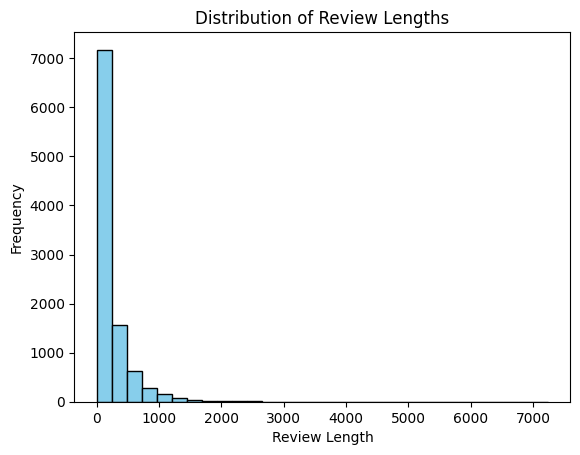

Mean Length: 224.9110733219966
Median Length: 116.0
25th, 50th, 75th Percentiles: 
0.25     47.0
0.50    116.0
0.75    270.0
Name: Review_Length, dtype: float64
Number of reviews longer than 25: 8630
Number of reviews longer than 50: 7328
Number of reviews longer than 100: 5415


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

review_lengths = df_subset['Review_Length']
# Plotting histogram to analyze distribution
plt.hist(review_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

mean_length = review_lengths.mean()
median_length = review_lengths.median()
percentiles = review_lengths.quantile([0.25, 0.5, 0.75])

print(f"Mean Length: {mean_length}")
print(f"Median Length: {median_length}")
print(f"25th, 50th, 75th Percentiles: \n{percentiles}")

thresholds = [25, 50, 100]
for threshold in thresholds:
    good_reviews = review_lengths[review_lengths > threshold].count()
    print(f"Number of reviews longer than {threshold}: {good_reviews}")

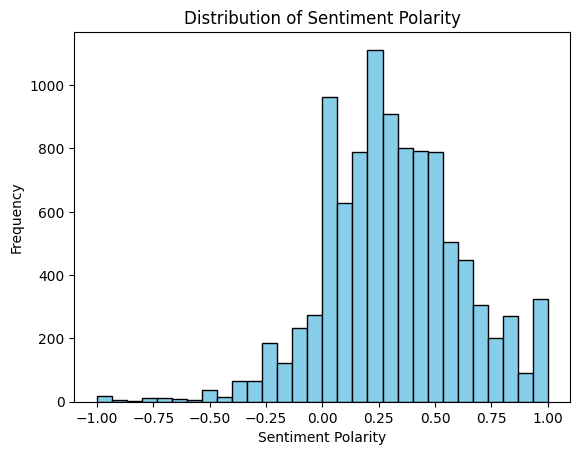

Mean Polarity: 0.31136386076683165
Median Polarity: 0.3
25th, 50th, 75th Percentiles: 
0.25    0.12
0.50    0.30
0.75    0.50
Name: Sentiment_Score, dtype: float64


In [5]:
import matplotlib.pyplot as plt

# Analyze sentiment polarity distribution
plt.hist(df_subset['Sentiment_Score'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Polarity')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

mean_polarity = df_subset['Sentiment_Score'].mean()
median_polarity = df_subset['Sentiment_Score'].median()
percentiles = df_subset['Sentiment_Score'].quantile([0.25, 0.5, 0.75])

print(f"Mean Polarity: {mean_polarity}")
print(f"Median Polarity: {median_polarity}")
print(f"25th, 50th, 75th Percentiles: \n{percentiles}")

XGBoost Algorithm
Model saved to 'xgb_model.pkl'
Accuracy: 0.9385
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.93       976
           1       0.90      1.00      0.94      1024

    accuracy                           0.94      2000
   macro avg       0.95      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



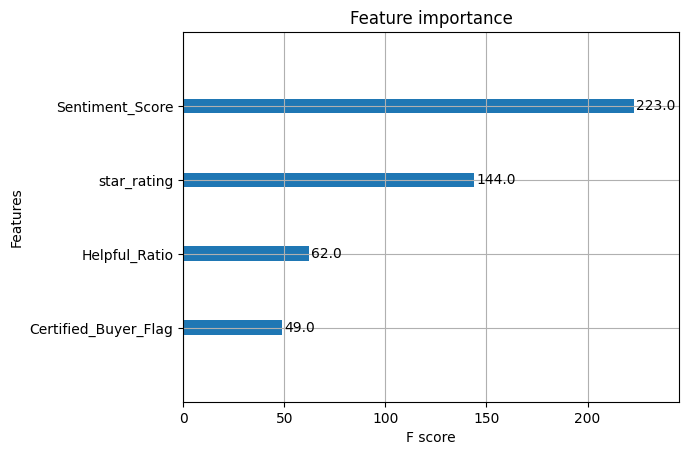

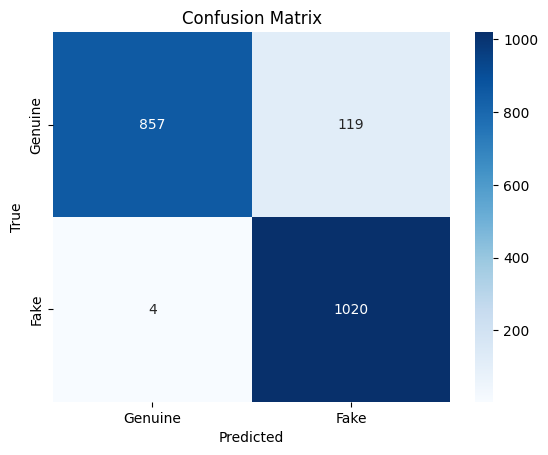

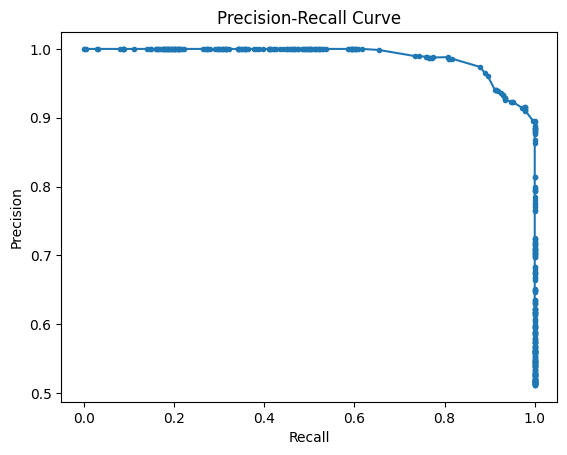

Random Forest Classifier Algorithm
Accuracy: 0.94
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.94       976
           1       0.91      0.98      0.94      1024

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000

Model saved to 'rf_model.pkl'


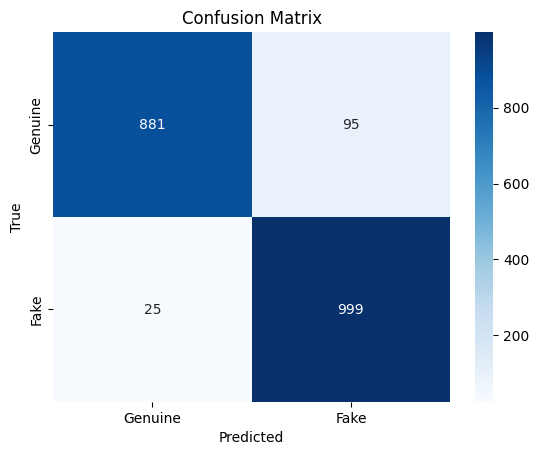

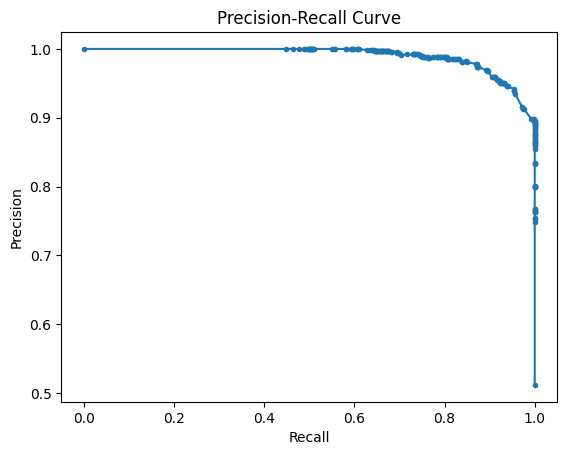

SVM Classifier Algorithm
Class distribution in y_train:
authenticity
1    4095
0    3902
Name: count, dtype: int64
Accuracy: 0.9025
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89       976
           1       0.87      0.95      0.91      1024

    accuracy                           0.90      2000
   macro avg       0.91      0.90      0.90      2000
weighted avg       0.91      0.90      0.90      2000



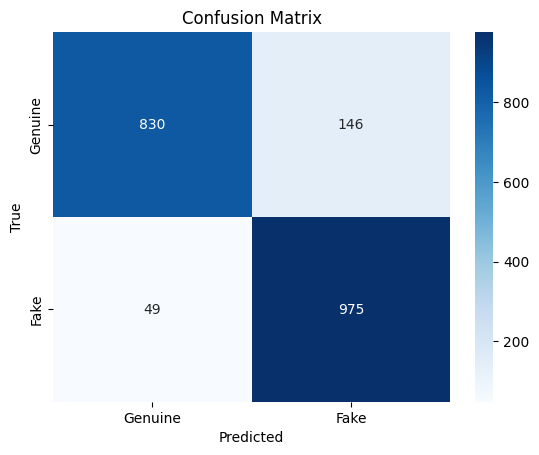

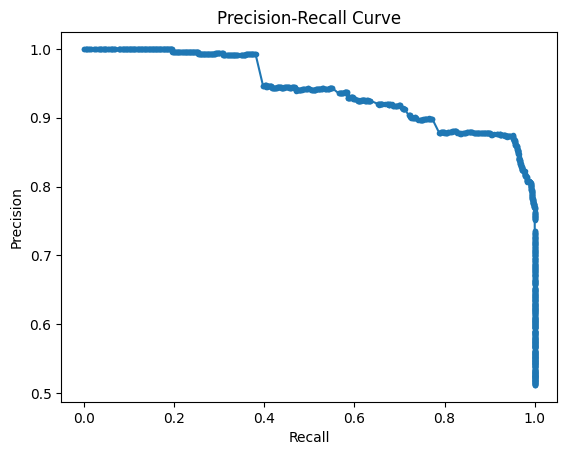

authenticity            1.000000
Helpful_Ratio           0.625656
Sentiment_Score         0.245648
Certified_Buyer_Flag    0.219152
star_rating             0.187337
Name: authenticity, dtype: float64


In [6]:
#Training,testing the model
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from collections import Counter

percentiles_sentiment = df_subset['Sentiment_Score'].quantile(0.5)
percentiles_review = review_lengths.quantile(0.25)
df_subset['authenticity'] = (
    (
        (df_subset['Certified_Buyer_Flag'] == 1) &
        (df_subset['Duplicate_Review_Flag'] == 0) &
        (df_subset['Sentiment_Score'] >= percentiles_sentiment) &
        (df_subset['star_rating'] > 2)|
        (df_subset['Helpful_Ratio'] > 0.5))
    
).astype(int)
X = df_subset[['star_rating','Certified_Buyer_Flag', 'Helpful_Ratio','Sentiment_Score']]  
y = df_subset['authenticity']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
counter = Counter(y_train)
majority = counter[0]  
minority = counter[1]  
scale_pos_weight = majority / minority
print("XGBoost Algorithm")
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    n_estimators=100,   
    learning_rate=0.1,      
    max_depth=3, 
    subsample=0.8,  # Randomly sampling 80% of data to prevent overfitting
    colsample_bytree=0.7,
    random_state=42         
)
xgb_model.fit(X_train, y_train)
# Saving the model using joblib
joblib.dump(xgb_model, 'xgb_model.pkl')
print("Model saved to 'xgb_model.pkl'")
y_pred = xgb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
plot_importance(xgb_model)
plt.show()

# Generating confusion matrix
cm = confusion_matrix(y_test, y_pred)  
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Genuine','Fake'], yticklabels=['Genuine','Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

precision, recall, _ = precision_recall_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])

# Plotting Precision-Recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

#Random Forest Classifier Algorithm
print("Random Forest Classifier Algorithm")
rf_model = RandomForestClassifier(
    n_estimators=300,      
    max_depth=10, 
    class_weight = 'balanced',
    random_state=42    
)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

joblib.dump(rf_model, 'rf_model.pkl')
print("Model saved to 'rf_model.pkl'")

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Genuine', 'Fake'], yticklabels=['Genuine', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
# Plotting Precision-Recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# SVM Classifier 
print("SVM Classifier Algorithm")
print("Class distribution in y_train:")
print(y_train.value_counts())
svm_model = SVC(
    kernel='rbf',        
    probability=True,
    class_weight='balanced',
    random_state=42      
)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# Generating confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Genuine', 'Fake'], yticklabels=['Genuine', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, svm_model.predict_proba(X_test)[:, 1])

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

import pandas as pd

df_train = X_train.copy()
df_train['authenticity'] = y_train
correlations = df_train.corr()['authenticity'].sort_values(ascending=False)
print(correlations)

In [7]:
print(df_subset[['Review_Text', 'star_rating', 'Sentiment_Score', 'authenticity']].head())

                                         Review_Text  star_rating  \
0  These Really Do Work Great, But You Do Need To...            4   
1  I love this dress. Absolute favorite for winte...            5   
2  Nice socks, great colors, just enough support ...            5   
3  I bought this for my husband and WOW, this is ...            5   
4  Perfect dress and the customer service was awe...            5   

   Sentiment_Score  authenticity  
0         0.123271             0  
1         0.279671             0  
2         0.525000             1  
3         0.146000             0  
4         1.000000             1  


In [8]:
print(df_subset['authenticity'].value_counts())  # Count of 0 (fake) and 1 (authentic)

authenticity
1    5119
0    4878
Name: count, dtype: int64


In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from textblob import TextBlob
import pandas as pd
import time
import numpy as np
import joblib
from sklearn.metrics.pairwise import cosine_similarity
import validators
from bs4 import BeautifulSoup  
from urllib.parse import urlparse

# Flipkart URL Validation Function
def is_valid_flipkart_url(url):
    if not validators.url(url): 
        return False
    
    parsed_url = urlparse(url)
    domain = parsed_url.netloc.lower()
    
    if "flipkart.com" in domain:
        return True
    return False

# User provides Flipkart Product Review URL
#base_url = "https://www.flipkart.com/motorola-g64-5g-ice-lilac-256-gb/product-reviews/itm1df450f035292?pid=MOBGY2JUGGJZJQNK&lid=LSTMOBGY2JUGGJQNKKF5P9H&marketplace=FLIPKART"
#base_url = input("Enter the Flipkart Product URL")
#base_url = "https://www.flipkart.com/realme-narzo-n61-marble-black-64-gb/product-reviews/itm0ffee8689770b?pid=MOBH39BEF7TFDH48&lid=LSTMOBH39BEF7TFDH48KU9ABF&marketplace=FLIPKART"
base_url = "https://www.flipkart.com/twisted-series-love-games-hate-lies/product-reviews/itme481697729867?pid=RBKGMPV9AG3PUXMJ&lid=LSTRBKGMPV9AG3PUXMJCB9GXF&marketplace=FLIPKART"
#base_url = "https://www.flipkart.com/realme-p3x-5g-midnight-blue-128-gb/product-reviews/itmab5a4b09b6ccc?pid=MOBH8VGV88UADK2Z&lid=LSTMOBH8VGV88UADK2ZH101KQ&marketplace=FLIPKART"
#base_url = "https://www.flipkart.com/motorola-g64-5g-ice-lilac-256-gb/product-reviews/itm1df450f035292?pid=MOBGY2JUGGJZJQNK&lid=LSTMOBGY2JUGGJZJQNKKF5P9H&marketplace=FLIPKART"  

if not is_valid_flipkart_url(base_url):
    print("Error: The provided URL is not a valid Flipkart website.")
    exit()

import requests

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# Configure Selenium WebDriver
chrome_options = Options()
chrome_options.add_argument("--headless")  # Run in headless mode (optional)
chrome_driver_path = r"C:\Program Files (x86)\chromedriver-win64\chromedriver.exe"  # Update with correct path
service = Service(chrome_driver_path)
driver = webdriver.Chrome(service=service, options=chrome_options)

# Initialize lists to store review data
Review_Text = []
star_rating = []
Helpful_Count = []
Duplicate_Review_flag = []
unhelpful_votes = []
Certified_Buyer_Flag = []
review_headline = []

page = 1  
max_pages = 50

try:
    while page<=max_pages:
        print(f"Scraping page {page}...")
        driver.get(f"{base_url}&page={page}")
        soup = BeautifulSoup(driver.page_source, "html.parser")

        Review_Text += [r.text.strip() for r in soup.find_all("div", class_="ZmyHeo")]
        review_headline += [r.text.strip() for r in soup.find_all("p", class_="z9E0IG")]
        star_rating += [r.text.strip() for r in soup.find_all("div", class_="XQDdHH Ga3i8K")]
        Helpful_Count += [r.text.strip() if r else "0" for r in soup.find_all("div", class_="_6kK6mk")]
        unhelpful_votes += [r.text.strip() if r else "0" for r in soup.find_all("div", class_="_6kK6mk aQymJL")]
        Certified_Buyer_Flag += ["1" if "Certified Buyer" in str(r) else "0" for r in soup.find_all("span")]
        
        page+=1

        # Checking if "Next" button exists
        try:
            if not soup.find("a", {"class": "_9QVEpD"}):
                #print("No more pages found. Stopping.")
                break  

            if page > max_pages:
                #print("Reached max pages limit. Stopping.")
                break 
        except:
            print("No more pages to scrape.")
            break 

except Exception as e:
    print(f"Error while scraping: {e}")
driver.quit()

# Ensuring all lists have the same length
max_length = max(len(Review_Text), len(Helpful_Count), len(unhelpful_votes), len(Certified_Buyer_Flag), len(star_rating), len(review_headline))

Review_Text += [""] * (max_length - len(Review_Text))
star_rating += ["0"] * (max_length - len(star_rating))
review_headline += [""] * (max_length - len(review_headline))
Helpful_Count += ["0"] * (max_length - len(Helpful_Count))
unhelpful_votes += ["0"] * (max_length - len(unhelpful_votes))
Certified_Buyer_Flag += ["0"] * (max_length - len(Certified_Buyer_Flag))
total_votes = [int(h) + int(u) for h, u in zip(Helpful_Count, unhelpful_votes)]
df = pd.DataFrame({
    "Review_Text": Review_Text,
    "Helpful_Count": Helpful_Count,
    "unhelpful_votes": unhelpful_votes,
    "Certified_Buyer_Flag": Certified_Buyer_Flag,
    "review_headline": review_headline,
    "star_rating": star_rating
})
df['Sentiment_Score'] = df['Review_Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df.to_csv("flipkart_reviews.csv", index=False)
#print("Reviews successfully saved to flipkart_reviews.csv")
#print(df.head(20))

try:
    tfidf = joblib.load('tfidf_vectorizer.pkl')  
    X_tfidf = tfidf.transform(df['Review_Text'])
    similarity_matrix = cosine_similarity(X_tfidf)
    threshold = 0.8
    df['Duplicate_Review_Flag'] = (similarity_matrix > threshold).any(axis=1).astype(int)

except FileNotFoundError:
    print("Error: TF-IDF vectorizer file not found. Ensure the file exists.")
    exit()

df['Review_Length'] = df['Review_Text'].apply(len) 
df['Helpful_Count'] = pd.to_numeric(df['Helpful_Count'], errors='coerce').fillna(0).astype(float)
df['unhelpful_votes'] = pd.to_numeric(df['unhelpful_votes'], errors='coerce').fillna(0).astype(float)
df['Helpful_Ratio'] = df['Helpful_Count'] / (df['Helpful_Count']+df['unhelpful_votes']+1) 
df['Certified_Buyer_Flag'] = pd.to_numeric(df['Certified_Buyer_Flag'], errors='coerce').fillna(0)
df['star_rating'] = pd.to_numeric(df['star_rating'],errors = 'coerce').fillna(0)
df['Duplicate_Review_Flag'] = pd.to_numeric(df['Duplicate_Review_Flag'],errors='coerce').fillna(0)

# Prepare input features matching the model
import numpy as np

try:
    model = joblib.load('xgb_model.pkl')
    #print("Model loaded successfully.")
except FileNotFoundError:
    print("Error: Model file not found.")
    exit()

# Prepare input features
X_input = df[['star_rating', 'Helpful_Ratio', 'Sentiment_Score', 'Certified_Buyer_Flag']].values

base_threshold = 0.5  
review_count = len(df)

if review_count == 0:
    final_product_prediction = "No reviews for this product"
elif review_count < 10:
    final_product_prediction = "Less reviews, can't predict accurately"
else:

    df["predicted_review"] = model.predict(X_input)

    # **🔹 Step 6: Aggregate Predictions for Product Decision**
    product_prediction = df["predicted_review"].median()
      
    
    # Adjust threshold based on sentiment and ratings
    avg_star_rating = df["star_rating"].mean()
    avg_sentiment = df["Sentiment_Score"].mean()
    certified_ratio = df["Certified_Buyer_Flag"].mean()
    helpful_ratio = df["Helpful_Ratio"].mean()
    duplicate_review_ratio = df['Duplicate_Review_Flag'].mean()
    # Start with a more neutral threshold
    dynamic_threshold = 0.50  
    
    # Adjustments based on different factors
    rating_adjustment = 0.015 * (avg_star_rating - 4.0)  
    dynamic_threshold -= rating_adjustment  
    
    certified_adjustment = 0.04 * (certified_ratio - 0.5)  
    dynamic_threshold -= certified_adjustment  
    
    sentiment_adjustment = 0.03 * (avg_sentiment - 0.5)  
    dynamic_threshold -= sentiment_adjustment  
    
    helpful_adjustment = 0.02 * (helpful_ratio - 0.5)  
    dynamic_threshold -= helpful_adjustment  
    
    duplicate_adjustment = 0.05 * duplicate_review_ratio  
    dynamic_threshold += duplicate_adjustment  
    
    # Soft threshold bounds
    dynamic_threshold = max(0.40, min(dynamic_threshold, 0.55))  
    
    # Compute final authenticity score (adjusted formula)
    final_authenticity_score = (avg_star_rating * 0.35) + (certified_ratio * 0.3) + \
                               (avg_sentiment * 0.2) + (helpful_ratio * 0.25) - \
                               (duplicate_review_ratio * 0.3)
    
    # Debugging: Print key values
    print(f"🧐 Avg Star Rating: {avg_star_rating}, Adjustment: {rating_adjustment}")
    print(f"🛡️ Certified Ratio: {certified_ratio}, Adjustment: {certified_adjustment}")
    print(f"💬 Avg Sentiment: {avg_sentiment}, Adjustment: {sentiment_adjustment}")
    print(f"👍 Helpful Ratio: {helpful_ratio}, Adjustment: {helpful_adjustment}")
    print(f"🔁 Duplicate Review Ratio: {duplicate_review_ratio}, Adjustment: {duplicate_adjustment}")
    print(f"🚨 Final Dynamic Threshold: {dynamic_threshold}")
    print(f"✅ Final Authenticity Score: {final_authenticity_score}")
    
    # Make final prediction
    if final_authenticity_score >= dynamic_threshold:
        print("✅ Final Product Prediction: Good")
    else:
        print("❌ Final Product Prediction: Bad")


    


Scraping page 1...
